# Automated Monthly Report (Supplemental Sales Visualizations)

### Set Up

In [67]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fpdf import FPDF
import geopandas as gpd
from matplotlib.ticker import FuncFormatter

##### ----- Review These Values Monthly -----

In [68]:
#Change this every month 
this_month = ""
this_year = ""

#Set Paths for Extra Values
file_path = r"" #Data CSV taken from Shopify
file_path_departments = r"" # File mapping vendors to departments
path_to_map = r"" # us states json
path_to_logo = r"" # AP Logo

In [69]:
#Read in and prepare data

#Read in main df
df = pd.read_csv(file_path)

#Select only the columns needed for the analysis
df = df[['Paid at', 'Subtotal', 'Taxes', 'Total', 'Discount Amount',
        'Vendor', 'Shipping Province Name']]

#Remove NAs
df.dropna(subset = ['Paid at'], inplace = True)

#read in department assignment csv
departments_df = pd.read_csv(file_path_departments)

#assign department
df = df.merge(departments_df, on = 'Vendor', how = 'inner')

#format date
df['Datetime'] = pd.to_datetime(df['Paid at'], format = '%m/%d/%y %H:%M')

#separate the time into month, day, year and time
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Time'] = df['Datetime'].dt.strftime('%H:%M')

df = df.drop(columns = ['Paid at'])

df.columns = df.columns.str.lower()

## Visualization Building and Stat Extraction

##### Extract Metadata

In [70]:
#Count Unique Vendors
unique_vendors = df['vendor'].unique()
count_vendors = len(unique_vendors)
print("\nThere are", count_vendors, "unique vendors.")

#Count and see unique departments
unique_departments = df['department'].unique()
count_departments = len(unique_departments)
print("\nThere are", count_departments, "unique departments.\n")
print("Here are the unique departments listed out:")
print(unique_departments)

#See Total rows and columns
print("\nThis is the size of the dataframe (Rows, Columns):", df.shape)



There are 60 unique vendors.

There are 14 unique departments.

Here are the unique departments listed out:
['Jewelry' 'Lifestyle' 'Children' 'Housewares' 'Handbags' 'Kitchenware'
 'Fashion' 'Gourmet' 'Unknown' 'Bath' 'Apparel' 'Paint' 'Men' 'Stationary']

This is the size of the dataframe (Rows, Columns): (312, 13)


### Function for top vendors bar chart

In [71]:
def plot_top_sellers_by_vendor(df):
    total_sales_by_vendor = df.groupby('vendor')['subtotal'].sum().reset_index()

    # Sort the vendors by total sales in descending order and take the top 10
    top_10_vendors = total_sales_by_vendor.nlargest(10, 'subtotal')

    # Create a custom Seaborn color palette with at least 10 colors
    my_palette = sns.color_palette("husl", 10)

    # Create a bar graph using Seaborn
    plt.figure(figsize=(8, 6))

    # Define a custom formatter to add dollar signs to y-axis labels
    def currency_formatter(x, pos):
        return f"${x:,.0f}"

    y_format = FuncFormatter(currency_formatter)

    # Define the background color (vanilla)
    background_color = 'floralwhite'

    plt.gca().yaxis.set_major_formatter(y_format)

    sns.barplot(x='vendor', y='subtotal', data=top_10_vendors, palette=my_palette)
    #plt.xlabel('Vendor', fontsize=16)
    #plt.ylabel('Total Sales', fontsize=16)
     # Remove x and y-axis labels
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Sales by Vendor (Top 10)', fontsize=20)
    plt.xticks(rotation=35)  # Rotate x-axis labels by 45 degrees
    plt.savefig('vendor_bar.png', bbox_inches='tight', facecolor = background_color)

### Function for top departments bar chart

In [72]:
def plot_top_sellers_by_department(df):
    total_sales_by_department = df.groupby('department')['subtotal'].sum().reset_index()

    # Sort the departments by total sales in descending order and take the top 10
    top_10_departments = total_sales_by_department.nlargest(10, 'subtotal')

    # Create a custom Seaborn color palette with at least 10 colors
    my_palette = sns.color_palette("husl", 10)

    # Create a bar graph using Seaborn
    plt.figure(figsize=(8, 6))

    # Define a custom formatter to add dollar signs to y-axis labels
    def currency_formatter(x, pos):
        return f"${x:,.0f}"

    y_format = FuncFormatter(currency_formatter)

    # Define the background color (vanilla)
    background_color = 'floralwhite'

    plt.gca().yaxis.set_major_formatter(y_format)

    sns.barplot(x='department', y='subtotal', data=top_10_departments, palette=my_palette)
    #plt.xlabel('Department', fontsize=16)
    #plt.ylabel('Total Sales', fontsize=16)
    # Remove x and y-axis labels
    plt.xlabel('', fontsize=18)  # Adjust the fontsize as needed
    plt.ylabel('', fontsize=18)  # Adjust the fontsize as needed
    plt.title('Sales by Department (Top 10)', fontsize=20)
    plt.xticks(rotation=35)  # Rotate x-axis labels by 45 degrees
    plt.savefig('department_bar.png', bbox_inches='tight', facecolor = background_color)

##### Pie Chart Showing Top 5 Vendors and their % of Total Sales

In [73]:
def create_pie_chart_vendors(df):
    # Group the data by vendor, sum the total sales for each
    vendor_sales = df.groupby('vendor')['subtotal'].sum().reset_index()

    # Sort the data by total sales in descending order
    vendor_sales = vendor_sales.sort_values('subtotal', ascending=False)

    # Get the top 5 vendors
    top_5_vendors = vendor_sales.head(5)

    # Calculate the total sales for the entire dataset
    total_sales_all = vendor_sales['subtotal'].sum()

    # Create a DataFrame for the pie chart
    other_vendor_sales = pd.DataFrame({'vendor': ['Other'], 'subtotal': [total_sales_all - top_5_vendors['subtotal'].sum()]})
    pie_data = pd.concat([top_5_vendors, other_vendor_sales], ignore_index=True)

    # Create labels for the pie chart
    labels = pie_data['vendor'].tolist()

    # Create values for the pie chart
    values = pie_data['subtotal'].tolist()

    # Define the "husl" color palette
    husl_palette = sns.color_palette("husl", 6)

    # Define the background color (vanilla)
    background_color = 'floralwhite'

    # Create a pie chart
    plt.figure(figsize=(6, 6), facecolor=background_color)

    
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=husl_palette)

    plt.title('Top 5 Vendors Relative to Total', fontsize=20, fontfamily='serif', fontstyle='italic', y=0.92, x=0.5)

    plt.savefig('vendor_pie.png', bbox_inches='tight')

### Pie Chart showing Top 3 Departments as a total of sales

In [74]:
def create_pie_chart_departments(df):
    # Group the data by department, sum the total sales for each
    department_sales = df.groupby('department')['subtotal'].sum().reset_index()

    # Sort the data by total sales in descending order
    department_sales = department_sales.sort_values('subtotal', ascending=False)

    # Get the top 5 vendors
    top_3_departments = department_sales.head(3)

    # Calculate the total sales for the entire dataset
    total_sales_all = department_sales['subtotal'].sum()

    # Create a DataFrame for the pie chart
    other_department_sales = pd.DataFrame({'department': ['Other'], 'subtotal': [total_sales_all - top_3_departments['subtotal'].sum()]})
    pie_data = pd.concat([top_3_departments, other_department_sales], ignore_index=True)

    # Create labels for the pie chart
    labels = pie_data['department'].tolist()

    # Create values for the pie chart
    values = pie_data['subtotal'].tolist()

    # Define the "husl" color palette
    husl_palette = sns.color_palette("husl", 6)

    # Define the background color (vanilla)
    background_color = 'floralwhite'

    # Create a pie chart
    plt.figure(figsize=(6, 6), facecolor=background_color)
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=husl_palette)
    plt.title(f'Top 3 Departments Relative to Total', fontsize=20, fontfamily='serif', fontstyle='italic', y=0.92, x=0.5)

    plt.savefig('department_pie.png', bbox_inches='tight')


### Function for Total Sales by Hour

In [75]:
def sales_by_hour():

    df['time'] = pd.to_datetime(df['time'], format='%H:%M')

    # Extract the hour and create a new 'hour' column
    df['hour'] = df['time'].dt.floor('H').dt.hour   
    
    
    hourly_sales = df.groupby('hour')['subtotal'].sum().reset_index()

    
    # Create a time series plot using Seaborn
    plt.figure(figsize=(10, 6))
    # Define a custom formatter to add dollar signs to y-axis labels
    def currency_formatter(x, pos):
        return f"${x:,.0f}"

    y_format = FuncFormatter(currency_formatter)

    plt.gca().yaxis.set_major_formatter(y_format)

    # Define the background color (vanilla)
    background_color = 'floralwhite'


    sns.lineplot(x='hour', y='subtotal', data=hourly_sales, marker='o', linewidth = 3)
    plt.xlabel('Hour', fontsize = 18)
    plt.ylabel('', fontsize = 1)
    plt.title('Total Sales by Hour', fontsize = 20)
    plt.xticks(range(24))
    plt.grid(True)
    plt.savefig('sales_by_hour.png', bbox_inches='tight', facecolor = background_color)
    

### Sales by State Heat Map

In [76]:
def sales_map():

    gdf_us_states = gpd.read_file(path_to_map)

    # Calculate count of sales by state
    online_sales_df = df.groupby('shipping province name')['subtotal'].count().reset_index()

    # Rename the columns for clarity
    online_sales_df.columns = ['shipping province name', 'sales_count']

    # Merge the GeoDataFrame with the sales data
    gdf_sales = gdf_us_states.merge(online_sales_df, left_on='name', right_on='shipping province name')

    # Drop rows with missing values in 'state' or 'sales_count'
    gdf_sales = gdf_sales.dropna(subset=['shipping province name', 'sales_count'])

    # Plot the map with the heatmap
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.set_facecolor('floralwhite')  # Set the background color

    gdf_sales.plot(column='sales_count', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=False)

    # Add labels with the number of sales
    for x, y, label in zip(gdf_sales.geometry.centroid.x, gdf_sales.geometry.centroid.y, gdf_sales['sales_count']):
        ax.text(x, y, f'{label}', fontsize=8, ha='center', va='center')

    ax.set_title('Number of Online Sales by State', fontsize = 24)
    ax.set_axis_off()

    # Define the background color (vanilla)
    background_color = 'floralwhite'
    # Display the map
    plt.savefig('online_by_state.png', bbox_inches='tight', facecolor = background_color)


## Building the Report

##### FPDF

/var/folders/6x/8mbj3vjj307_hbvwh3t0hx0h0000gn/T/ipykernel_24651/2528665070.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='department', y='subtotal', data=top_10_departments, palette=my_palette)
/var/folders/6x/8mbj3vjj307_hbvwh3t0hx0h0000gn/T/ipykernel_24651/1520794908.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='vendor', y='subtotal', data=top_10_vendors, palette=my_palette)
/var/folders/6x/8mbj3vjj307_hbvwh3t0hx0h0000gn/T/ipykernel_24651/888759421.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(gdf_sa

''

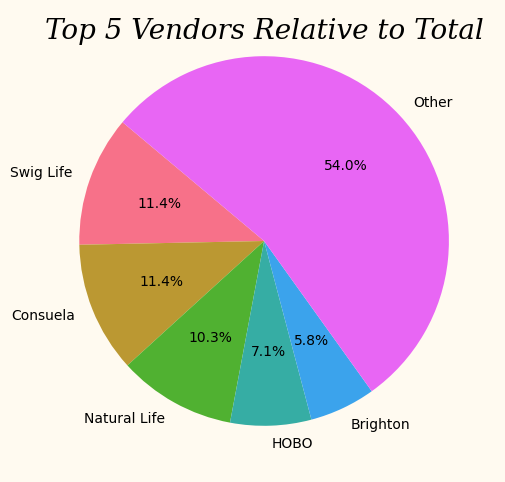

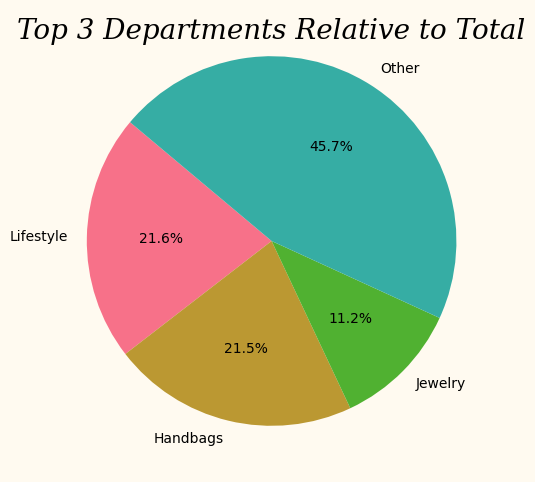

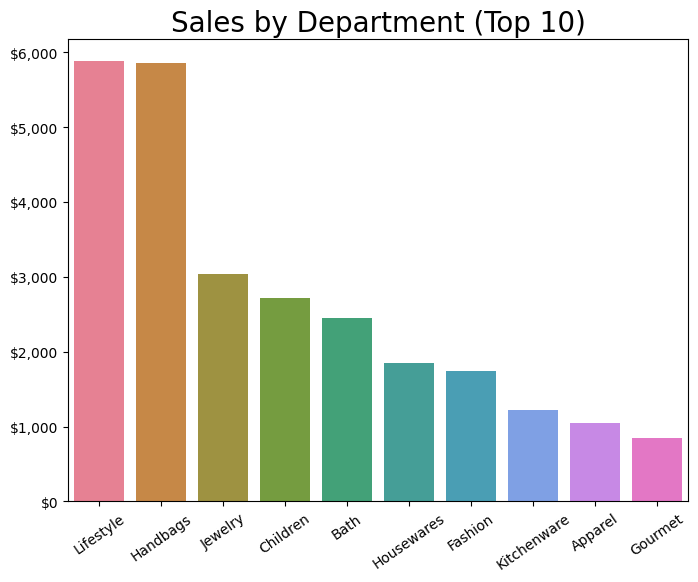

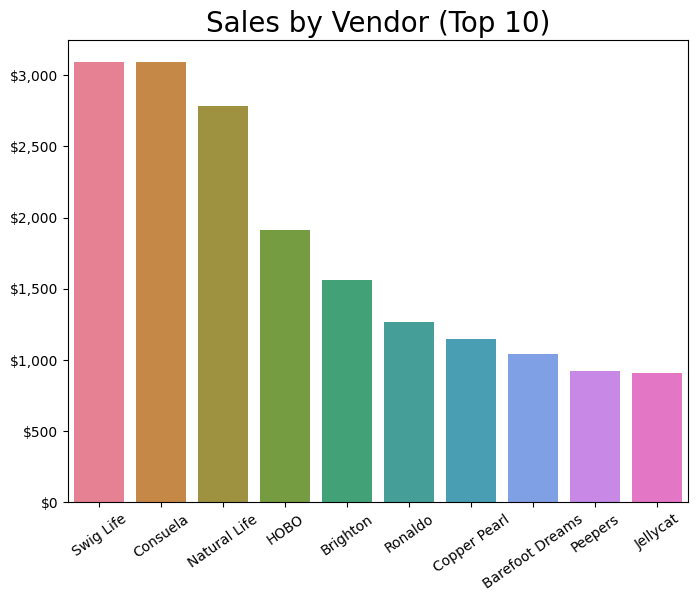

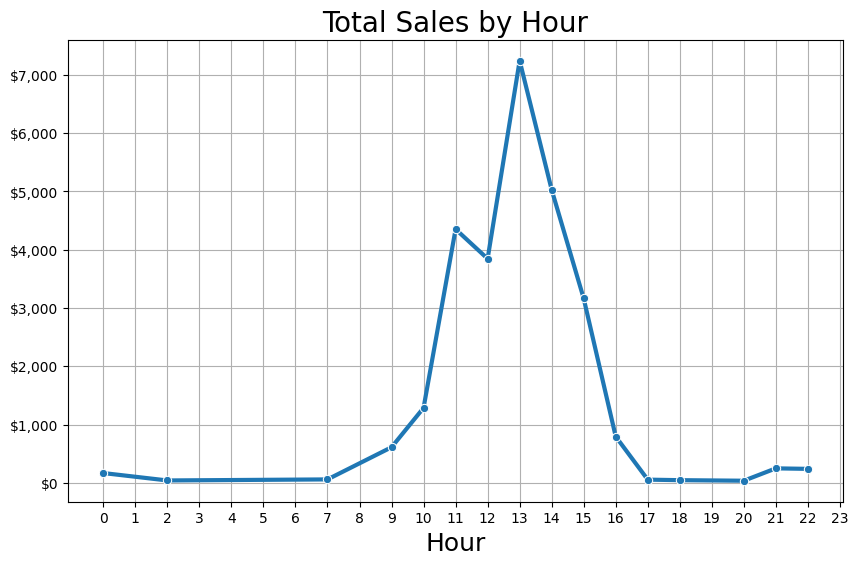

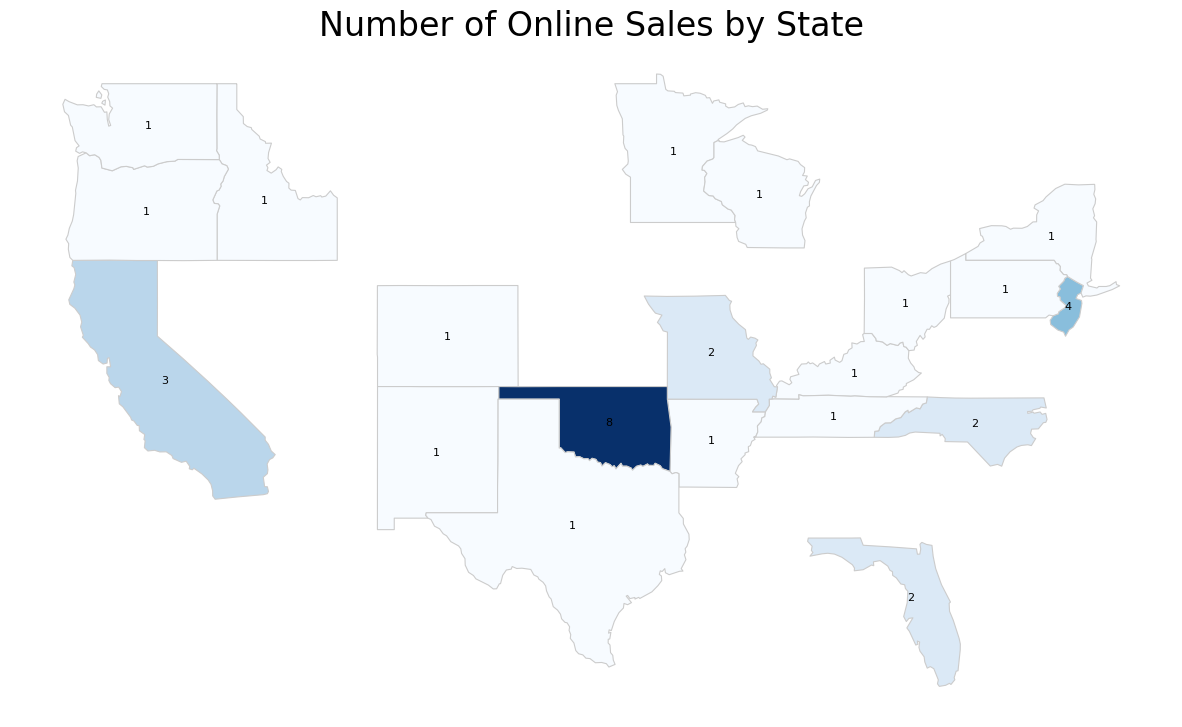

In [77]:
#Call on functions
create_pie_chart_vendors(df)
create_pie_chart_departments(df)
plot_top_sellers_by_department(df)
plot_top_sellers_by_vendor(df)
sales_by_hour()
sales_map()

WIDTH = 210

class MyPDF(FPDF):
    def set_floralwhite_background(self):
        # Set background color for the entire page
        self.set_fill_color(255, 250, 240)  # RGB values for 'floralwhite'
        self.rect(0, 0, self.w, self.h, 'F')


#Build Report
pdf = MyPDF()
pdf.add_page()
pdf.set_floralwhite_background()
pdf.set_font('Times', 'B', 22)

#----------------------------------------
# ------- Add and center Title ----------

pdf.set_font('Times', 'B', 22)
text = f'Sales Analytics Report for {this_month} {this_year}'
pdf.set_x(pdf.l_margin)
pdf.set_y(43)  # Adjust the y-coordinate to move down
pdf.cell(pdf.w - 2 * pdf.l_margin, 10, text, ln=True, align='C')

#----------------------------------------
# ----- Add and center Sub-Title --------

pdf.set_font('Times', 'B', 12)
text2 = '(Values and Vendors Changed to Maintain Confidentiality)'
pdf.set_x(pdf.l_margin)
pdf.set_y(53)  # Adjust the y-coordinate to move down
pdf.cell(pdf.w - 2 * pdf.l_margin, 8, text2, ln=True, align='C')

#----------------------------------------
# -----Add additional information--------

pdf.set_font('Times', 'B', 12)  
total_sales = df['subtotal'].sum()

total_sales_by_vendor = df.groupby('vendor')['subtotal'].sum()
top_vendor = total_sales_by_vendor.idxmax()

total_online_sales = df.loc[~df['shipping province name'].isna(), 'subtotal'].sum()

# Find the top selling online vendor
top_online_vendor = df.loc[df['shipping province name'].isna(), 'vendor'].value_counts().idxmax()

pdf.cell(0, 8, f'Total Sales: ${total_sales:,.2f}                                                                Total Online Sales: ${total_online_sales:,.2f}', ln=True)
pdf.cell(0, 8, f'Top Selling Vendor: {top_vendor}                                            Top Selling Online Vendor: {top_online_vendor}', ln=True)


#------------------------------------------
#--------- Annepaige Image ----------------
icon_width = 120
icon_height = 40
icon_x = (WIDTH - icon_width) / 2
icon_y = 5

pdf.image(path_to_logo, icon_x, icon_y, icon_width, icon_height)

#------------------------------------------
#--------- Vendor Pie Chart ---------------
image_width = 100
image_height = 100
image_x = 5  # Center the image horizontally
image_y = 85

pdf.image("vendor_pie.png", image_x, image_y, image_width, image_height)

#------------------------------------------
#--------- Department Pie Chart -----------
image2_width = 100
image2_height = 100
image2_x = 105  
image2_y = 190

pdf.image("department_pie.png", image2_x, image2_y, image2_width, image2_height)

#------------------------------------------
#--------- Department Bar Chart -----------
image3_width = 100
image3_height = 100
image3_x = 5   
image3_y = 190

pdf.image("department_bar.png", image3_x, image3_y, image3_width, image3_height)

#------------------------------------------
#--------- Vendor Bar Chart ---------------
image4_width = 100
image4_height = 100
image4_x = 105   
image4_y = 85

pdf.image("vendor_bar.png", image4_x, image4_y, image4_width, image4_height)

#----------------------------------------------------------------------
#------------------------PAGE 2 ---------------------------------------

pdf.add_page()
pdf.set_floralwhite_background()
pdf.set_font('Times', 'B', 22)

#------------------------------------------
#--------- Annepaige Image ----------------

pdf.image("AnnePaige_Logo.png", icon_x, icon_y, icon_width, icon_height)


#------------------------------------------
#--------- Sales by Hour ---------------
image5_width = 175
image5_height = 100
image5_x = (WIDTH - image5_width) / 2  # Center the image horizontally
image5_y = 50
pdf.image("sales_by_hour.png", image5_x, image5_y, image5_width, image5_height)

#------------------------------------------
#--------- Sales Map ----------------------
image6_width = 175
image6_height = 100
image6_x = (WIDTH - image5_width) / 2  # Center the image horizontally
image6_y = 170
pdf.image("online_by_state.png", image6_x, image6_y, image6_width, image6_height)


# Output the PDF
pdf.output('monthly_report.pdf', 'F')
